In [1]:
import numpy as np
import re
import nltk
from datasets import load_dataset
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

import matplotlib.pyplot as plt

/Users/fanyupei/Codes/sentiment-analysis/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/fanyupei/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/fanyupei/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/fanyupei/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /Users/fanyupei/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/fanyupei/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package 

True

# Part 0. Dataset Preparation

In [3]:
# loading the dataset from the library
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset ['train']
validation_dataset = dataset ['validation']
test_dataset = dataset ['test']

In [4]:
# check the sizes of each dataset
train_size = len(train_dataset)
validation_size = len(validation_dataset)
test_size = len(test_dataset)

print(f"Training dataset size: {train_size}")
print(f"Validation dataset size: {validation_size}")
print(f"Test dataset size: {test_size}")

Training dataset size: 8530
Validation dataset size: 1066
Test dataset size: 1066


In [5]:
# view an example from each dataset
print("Train Dataset")
print(train_dataset.features)
print(train_dataset[0]) 

print("Test Dataset")
print(test_dataset.features)
print(test_dataset[0]) 

print("Validation Dataset")
print(validation_dataset.features)
print(validation_dataset[0])

Train Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'label': 1}
Test Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .', 'label': 1}
Validation Dataset
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': 'compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .', 'label': 1}


# Part 1. Preparing Word Embeddings

### Preprocessing

In [6]:
def preprocessing(text):

    # remove any other special characters but keep the general ones for potential sentiment usage
    text = re.sub(r'[^a-zA-Z0-9\'\!\?\.]', ' ', text)
    
    # replace multiple spaces with one space only
    text = re.sub(r'\s+', ' ', text)

    # remove leading and trailing whitespace to avoid unnecessary inconsistency 
    text = text.strip()

    return text

# apply the preprocessing function to the 'text' column of each dataset
train_dataset = train_dataset.map(lambda x: {'text': preprocessing(x['text'])})
validation_dataset = validation_dataset.map(lambda x: {'text': preprocessing(x['text'])})
test_dataset = test_dataset.map(lambda x: {'text': preprocessing(x['text'])})

# an example of the processed text
print("Train Dataset Example:")
print(train_dataset[0])

Train Dataset Example:
{'text': "the rock is destined to be the 21st century's new conan and that he's going to make a splash even greater than arnold schwarzenegger jean claud van damme or steven segal .", 'label': 1}


In [7]:
# tokenization
# empty list to store the resulting sentences
tokenized_sentences = []

for text in train_dataset['text']:
    # Tokenize the text and append the tokenized sentence to the list
    tokenized_sentences.append(word_tokenize(text))

### (a) Size of vocabulary in training data

In [8]:
# empty set for storing unique words
original_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the words set
        original_vocab.add(word)

print(f"(a) The size of vocabulary formed in the training data is {len(original_vocab)}")

(a) The size of vocabulary formed in the training data is 16683


### (b) Number of OOV in the training data

In [9]:
# adjust the parameters for word2vec
vector_size = 100 # Dimensionality of the word vectors
window = 3 # Maximum distance between the current and predicted word within a sentence
min_count = 2 # Ignores all words with total frequency lower than this
workers = 4 # CPU cores
sg = 1 # 1 for skip-gram, 0 for CBOW
epochs = 5 

# train the word2vec model
word2vec_model = Word2Vec(
    sentences = tokenized_sentences, 
    vector_size = vector_size, 
    window = window, 
    min_count = min_count, 
    workers = workers,
    epochs = epochs)

# variable to store model's vocab list 
word2vec_vocab = set(word2vec_model.wv.key_to_index)

# Calculate OOV words by comparing the original vocab and Word2Vec vocab
oov_words = original_vocab - word2vec_vocab

print(f"(b) Number of OOV words in the training data is {len(oov_words)} when the minimum threshold for each word is {min_count}")

(b) Number of OOV words in the training data is 7866 when the minimum threshold for each word is 2


### (c) Mitigating OOV - code snippet

In [10]:
# define the UNK and PAD token
UNK_TOKEN = '<UNK>'
PAD_TOKEN = '<PAD>'

def replace_oov_words(tokenized_sentences,vocab):
    # Replace all OOV words with <UNK>
    # process each sentence in the tokenized_sentences list
    for i, sentence in enumerate(tokenized_sentences):
        # empty list to store the current processed sentence
        processed_sentence = []
        for word in sentence:
            if word in vocab:
                # if the current word is in the model's vocab, keep it as it is
                processed_sentence.append(word)  
            else:
                # otherwise, replace the word with UNK
                processed_sentence.append(UNK_TOKEN) 

        # update the sentence in the original tokenized_sentences list
        tokenized_sentences[i] = processed_sentence

    return tokenized_sentences

### Embedding matrix

In [11]:
# empty set for storing unique words
final_vocab = set()

for sentence in tokenized_sentences:
    for word in sentence:
        # add each word in the sentence to the final_vocab set
        final_vocab.add(word)

# add 'UNK' and '<PAD>' to the vocabulary
final_vocab.add(UNK_TOKEN)
final_vocab.add(PAD_TOKEN)

# create the dictionary that maps each word in final_vocab to a unique index
word_to_index = {word: i for i, word in enumerate(final_vocab)}

embedding_dim = word2vec_model.vector_size 

# initialize embedding matrix with number of vocab and embedding dimension
embedding_matrix = np.zeros((len(word_to_index), embedding_dim))

# fill the embedding matrix with the corresponding word vectors
for word, i in word_to_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
    elif word == PAD_TOKEN:
        # give padding token a zero vector to have no impact on the word semantics
        embedding_matrix[i] = np.zeros(embedding_dim)
    else:
        # use average vector for unknown words 
        embedding_matrix[i] = np.mean(word2vec_model.wv.vectors, axis=0)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")

Shape of embedding matrix: (16685, 100)


In [12]:
# convert word to indices 
def words_to_indices(sentence, word_to_index):
    return [word_to_index.get(word, word_to_index[UNK_TOKEN]) for word in sentence.split()]

train_X = [words_to_indices(sentence, word_to_index) for sentence in train_dataset['text']]
train_y = train_dataset['label']
val_X = [words_to_indices(sentence, word_to_index) for sentence in validation_dataset['text']]
val_y = validation_dataset['label']
test_X = [words_to_indices(sentence, word_to_index) for sentence in test_dataset['text']]
test_y = test_dataset['label']

def create_dataloader(X, y, batch_size=16, shuffle=True):
    X_tensor = [torch.tensor(seq, dtype=torch.long) for seq in X]
    X_padded = pad_sequence(X_tensor, batch_first=True, padding_value=word_to_index[PAD_TOKEN])
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_padded, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = create_dataloader(train_X, train_y, shuffle=True)
val_dataloader = create_dataloader(val_X, val_y, shuffle=False)
test_dataloader = create_dataloader(test_X, test_y, shuffle=False)

# convert embedding_matrix to tensor
embedding_matrix = torch.FloatTensor(embedding_matrix)

# Part 2. Model Training & Evaluation - RNN

In [13]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
                 freeze_embeddings=True, aggregation_method='max_pooling',dropout_rate=0.2):
        super().__init__()
        
        # convert numpy embedding matrix to tensor
        embedding_tensor = torch.FloatTensor(embedding_matrix)
        
        self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
                                                      freeze=freeze_embeddings)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        # attention layer for attention aggregation method
        self.attention = nn.Linear(hidden_dim, 1)
        
        self.aggregation_method = aggregation_method
        
    def forward(self, text):
        #embedded = self.embedding(text)
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        
        if self.aggregation_method == 'last_hidden':
            # use the last hidden state
            sentence_repr = hidden.squeeze(0)
        elif self.aggregation_method == 'last_output':
            # use the last output
            sentence_repr = output[:, -1, :]
        elif self.aggregation_method == 'mean_pooling':
            # average all outputs
            sentence_repr = torch.mean(output, dim=1)
        elif self.aggregation_method == 'max_pooling':
            # max pooling over the sequence
            sentence_repr, _ = torch.max(output, dim=1)
        elif self.aggregation_method == 'attention':
            # Attention mechanism
            attention_weights = F.softmax(self.attention(output), dim=1)
            sentence_repr = torch.sum(attention_weights * output, dim=1)
        sentence_repr = self.dropout(sentence_repr)
        return self.fc(sentence_repr)

In [14]:
# shall we use bidirectional rnn?

# import torch.nn.functional as F

# class SentimentRNN(nn.Module):
#     def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, embedding_matrix, 
#                  freeze_embeddings=True, aggregation_method='max_pooling', dropout_rate=0.2):
#         super().__init__()
        
#         # convert numpy embedding matrix to tensor
#         embedding_tensor = torch.FloatTensor(embedding_matrix)
        
#         self.embedding = nn.Embedding.from_pretrained(embedding_tensor, padding_idx=pad_idx, 
#                                                       freeze=freeze_embeddings)
        
#         self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 because of bidirectional
#         self.dropout = nn.Dropout(dropout_rate)
#         # attention layer for attention aggregation method
#         self.attention = nn.Linear(hidden_dim * 2, 1)  # *2 because of bidirectional
        
#         self.aggregation_method = aggregation_method
        
#     def forward(self, text):
#         embedded = self.dropout(self.embedding(text))
#         output, hidden = self.rnn(embedded)
        
#         if self.aggregation_method == 'last_hidden':
#             # concatenate the last hidden state from both directions
#             sentence_repr = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
#         elif self.aggregation_method == 'last_output':
#             # concatenate the last output from both directions
#             sentence_repr = torch.cat((output[:, -1, :hidden.size(2)], 
#                                        output[:, 0, hidden.size(2):]), dim=1)
#         elif self.aggregation_method == 'mean_pooling':
#             # average all outputs
#             sentence_repr = torch.mean(output, dim=1)
#         elif self.aggregation_method == 'max_pooling':
#             # max pooling over the sequence
#             sentence_repr, _ = torch.max(output, dim=1)
#         elif self.aggregation_method == 'attention':
#             # Attention mechanism
#             attention_weights = F.softmax(self.attention(output), dim=1)
#             sentence_repr = torch.sum(attention_weights * output, dim=1)
        
#         sentence_repr = self.dropout(sentence_repr)
#         return self.fc(sentence_repr)

In [ ]:
# max pooling used for sentence aggregation
vocab_size = len(word_to_index)
embedding_dim = embedding_matrix.shape[1]  # match word2vec vector size
hidden_dim = 256
output_dim = 2  
pad_idx = word_to_index[PAD_TOKEN] if PAD_TOKEN in word_to_index else 0  

model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                     embedding_matrix, freeze_embeddings=True, 
                     aggregation_method='max_pooling')
print(model)

# verify embedding layer
print(f"Embedding layer shape: {model.embedding.weight.shape}")
print(f"Embedding layer requires gradient: {model.embedding.weight.requires_grad}")


SentimentRNN(
  (embedding): Embedding(16685, 100, padding_idx=12727)
  (rnn): RNN(100, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (attention): Linear(in_features=256, out_features=1, bias=True)
)
Embedding layer shape: torch.Size([16685, 100])
Embedding layer requires gradient: False


In [16]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, patience):
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, label = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(label, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        # validation
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, label = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, label)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(label, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                break
    
    return best_val_loss, val_acc

def calculate_accuracy(y_true, y_pred):
    return accuracy_score(y_true.numpy(), y_pred.numpy())

def hyperparameter_tuning(model, train_dataloader, val_dataloader):
    param_grid = {
        'lr': [0.01, 0.001, 0.0001],
        'weight_decay': [1e-5],
        'batch_size': [16, 32, 64],
        'num_epochs': [50],
        'patience': [5]
    }
    
    grid = ParameterGrid(param_grid)
    best_params = None
    best_val_loss = float('inf')
    best_val_acc = 0
    
    for params in grid: # Compare amoung the parameter grid and find the best parameters
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        
        val_loss, val_acc = train_and_evaluate(
            model, train_dataloader, val_dataloader, criterion, optimizer, 
            params['num_epochs'], params['patience']
        )
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_params = params
    
    return best_params, best_val_loss, best_val_acc

best_params, best_val_loss, best_val_acc = hyperparameter_tuning(model, train_dataloader, val_dataloader)
print(f"Best parameters: {best_params}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

# train using the best parameters
model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

final_val_loss, final_val_acc = train_and_evaluate(
    model, train_dataloader, val_dataloader, criterion, optimizer, 
    best_params['num_epochs'], best_params['patience']
)

print(f"Final validation loss: {final_val_loss:.4f}")
print(f"Final validation accuracy: {final_val_acc:.4f}")

# Save the best model
torch.save(model.state_dict(), 'best_model.pth')

Best parameters: {'batch_size': 64, 'lr': 0.0001, 'num_epochs': 50, 'patience': 5, 'weight_decay': 1e-05}
Best validation loss: 0.5902
Best validation accuracy: 0.6994
Final validation loss: 0.6003
Final validation accuracy: 0.6974


## Evaluate on test dataset

In [17]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()  
test_loss = 0
all_predictions = []
all_labels = []

with torch.no_grad():  
    for inputs, label in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, label)
        
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

test_loss /= len(test_dataloader)
test_acc = accuracy_score(all_labels, all_predictions)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.5696
Test Accuracy: 0.6989


## c) Sentence aggregation : max pooling is the best (test using best parameters from previous section)

In [18]:
# test for word representation aggregation ([ 'mean_pooling', 'max_pooling'])
def train_model(aggregation_method, num_epochs=50, learning_rate=0.0001):
    model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                         embedding_matrix, freeze_embeddings=True, 
                         aggregation_method=aggregation_method)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    patience = 5
    epochs_without_improvement = 0
    
    train_losses, train_accs, val_losses, val_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        for batch in train_dataloader:
            inputs, labels = batch
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_acc += calculate_accuracy(labels, predicted)
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for batch in val_dataloader:
                inputs, labels = batch
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_acc += calculate_accuracy(labels, predicted)
        
        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), f'best_model_{aggregation_method}.pth')
        else:
            epochs_without_improvement += 1
        
        if epochs_without_improvement == patience:
            print("Early stopping triggered")
            break
    
    return train_losses, train_accs, val_losses, val_accs

aggregation_methods = ['mean_pooling', 'max_pooling','last_hidden','last_output','attention']
results = {}

for method in aggregation_methods:
    print(f"\nTraining model with {method} aggregation method")
    train_losses, train_accs, val_losses, val_accs = train_model(method)
    results[method] = {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }


Training model with mean_pooling aggregation method
Epoch 1/50
Train Loss: 0.6896, Train Acc: 0.5320
Val Loss: 0.6842, Val Acc: 0.5800
Epoch 2/50
Train Loss: 0.6800, Train Acc: 0.5701
Val Loss: 0.6801, Val Acc: 0.5668
Epoch 3/50
Train Loss: 0.6749, Train Acc: 0.5865
Val Loss: 0.6766, Val Acc: 0.5841
Epoch 4/50
Train Loss: 0.6724, Train Acc: 0.5897
Val Loss: 0.6769, Val Acc: 0.5772
Epoch 5/50
Train Loss: 0.6725, Train Acc: 0.5860
Val Loss: 0.6748, Val Acc: 0.5813
Epoch 6/50
Train Loss: 0.6711, Train Acc: 0.5879
Val Loss: 0.6733, Val Acc: 0.5897
Epoch 7/50
Train Loss: 0.6679, Train Acc: 0.5904
Val Loss: 0.6854, Val Acc: 0.5815
Epoch 8/50
Train Loss: 0.6688, Train Acc: 0.5959
Val Loss: 0.6721, Val Acc: 0.5851
Epoch 9/50
Train Loss: 0.6670, Train Acc: 0.5936
Val Loss: 0.6761, Val Acc: 0.5968
Epoch 10/50
Train Loss: 0.6672, Train Acc: 0.5970
Val Loss: 0.6761, Val Acc: 0.6017
Epoch 11/50
Train Loss: 0.6669, Train Acc: 0.5947
Val Loss: 0.6728, Val Acc: 0.5875
Epoch 12/50
Train Loss: 0.6632, 

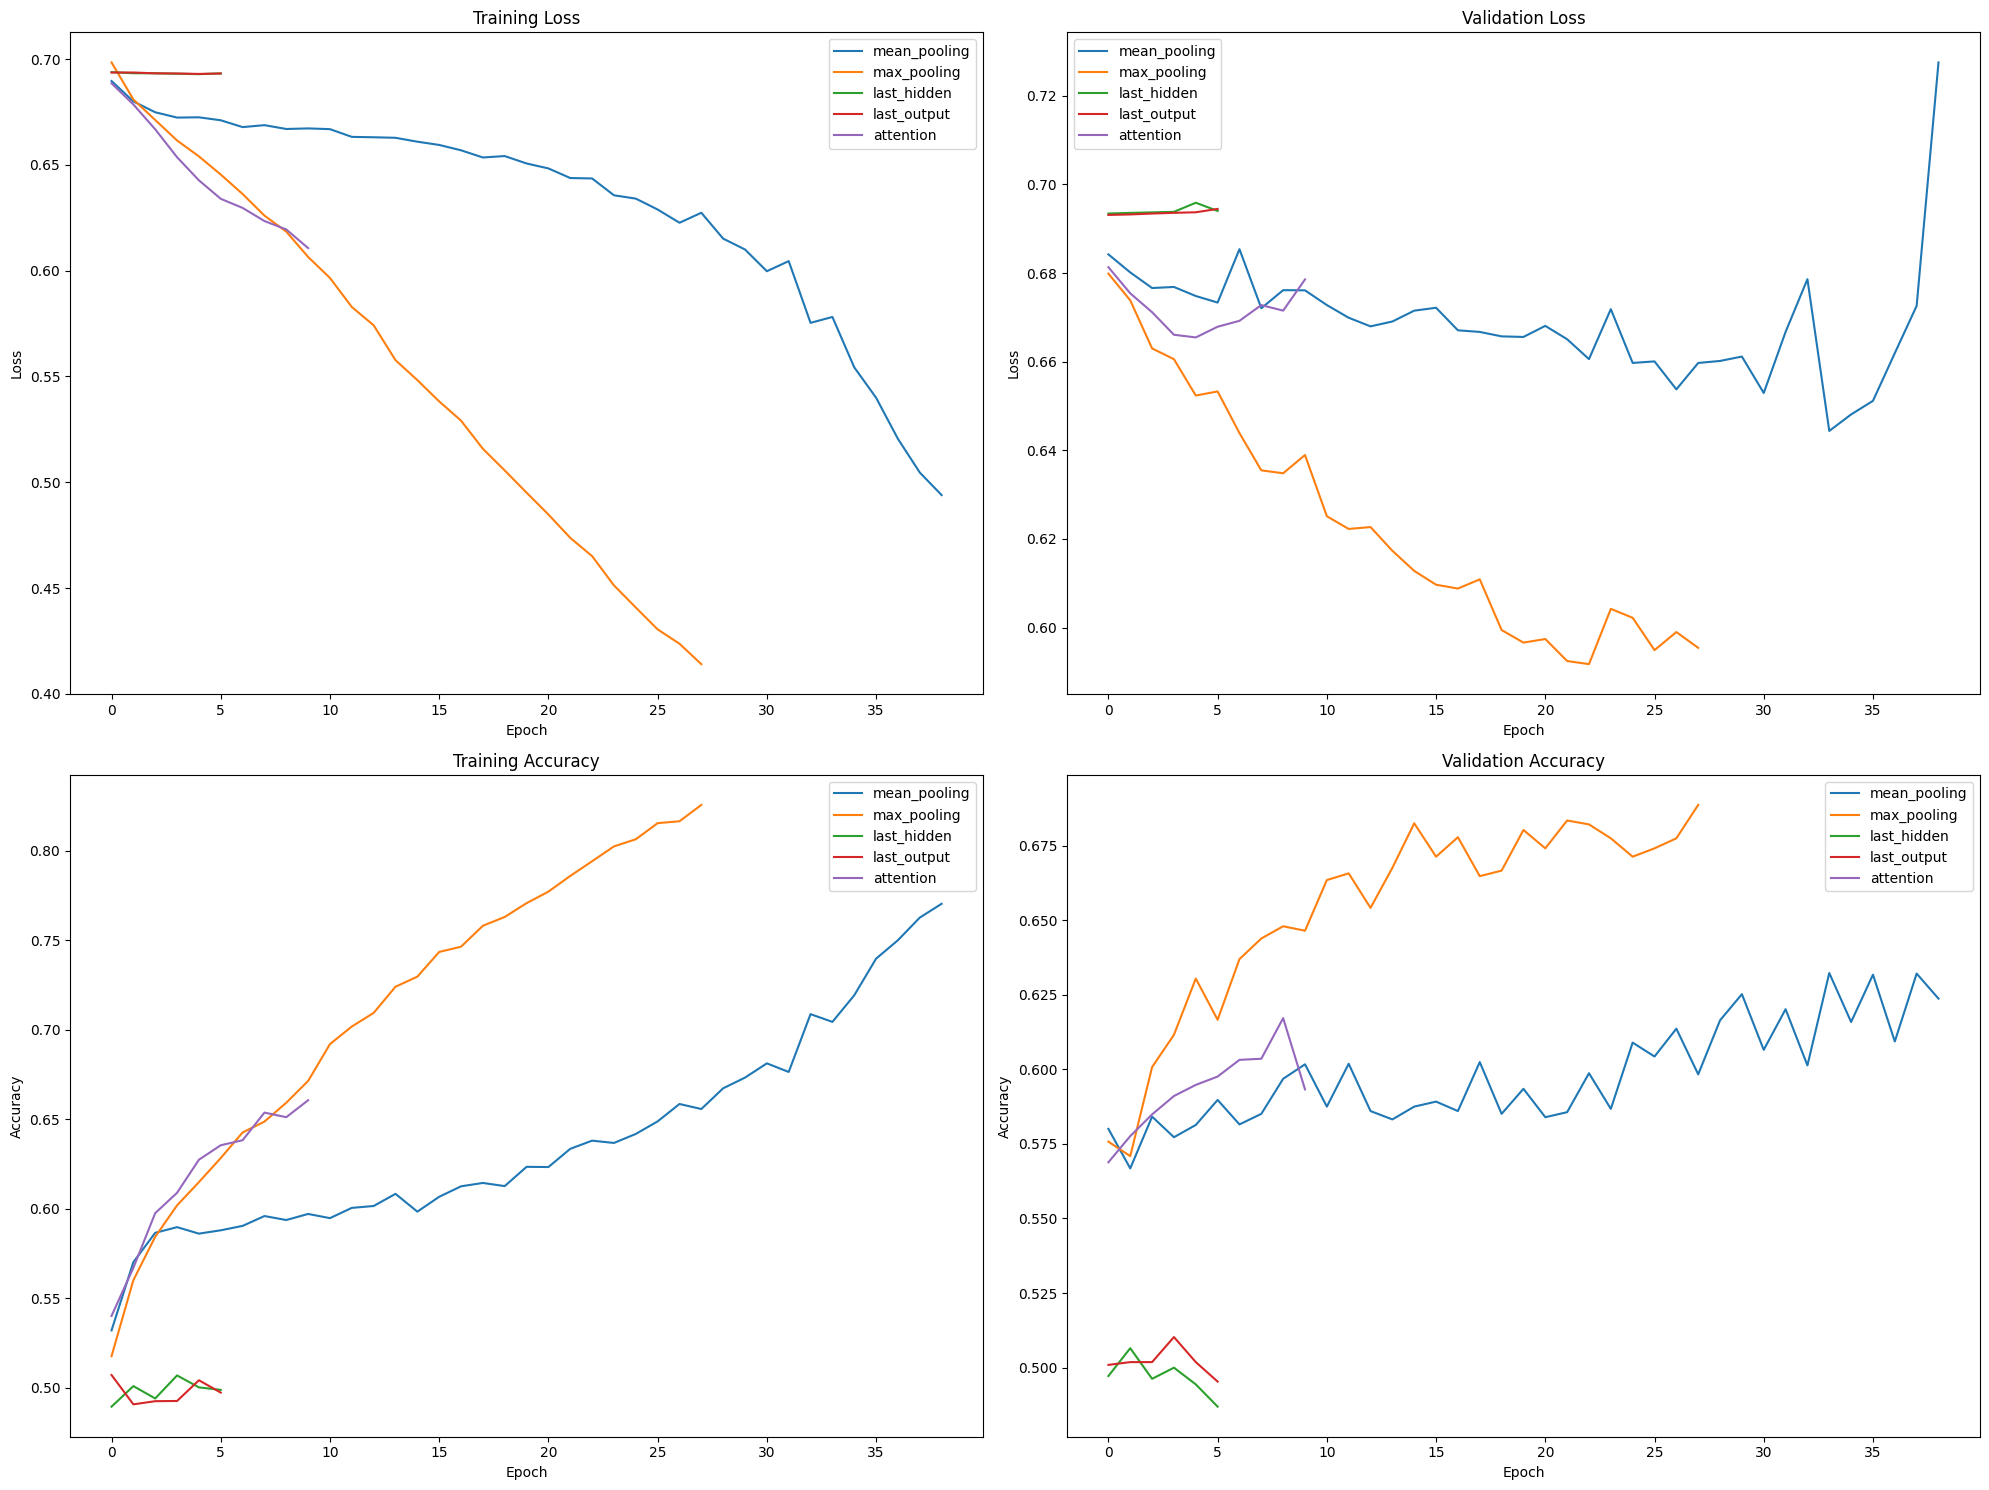

In [20]:
# plotting

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

for method in aggregation_methods:
    ax1.plot(results[method]['train_losses'], label=method)
    ax2.plot(results[method]['val_losses'], label=method)
    ax3.plot(results[method]['train_accs'], label=method)
    ax4.plot(results[method]['val_accs'], label=method)

ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

ax3.set_title('Training Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()

plt.tight_layout()
plt.savefig('aggregation_methods_comparison.png')
plt.show()

### Load Checkpointd and Highlight the Best in the Graph

In [22]:
import torch
import matplotlib.pyplot as plt

def load_and_evaluate_model(aggregation_method, val_dataloader, criterion):
    # Load model from the checkpoint
    model = SentimentRNN(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx, 
                         embedding_matrix, freeze_embeddings=True, 
                         aggregation_method=aggregation_method)
    model.load_state_dict(torch.load(f'best_model_{aggregation_method}.pth'))
    
    # Set model to evaluation mode
    model.eval()
    val_loss = 0
    val_acc = 0
    all_val_accs = []

    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_acc += calculate_accuracy(labels, predicted)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    return val_loss, val_acc

# Initialize criterion
criterion = nn.CrossEntropyLoss()
best_val_accuracies = {}

# Evaluate each aggregation method
for method in aggregation_methods:
    print(f"Evaluating best model for {method} aggregation method")
    val_loss, val_acc = load_and_evaluate_model(method, val_dataloader, criterion)
    best_val_accuracies[method] = val_acc
    print(f"Best Validation Accuracy for {method}: {val_acc:.4f}")

# Plotting with highlighted best points

Evaluating best model for mean_pooling aggregation method
Best Validation Accuracy for mean_pooling: 0.6323
Evaluating best model for max_pooling aggregation method
Best Validation Accuracy for max_pooling: 0.6821
Evaluating best model for last_hidden aggregation method
Best Validation Accuracy for last_hidden: 0.4972
Evaluating best model for last_output aggregation method
Best Validation Accuracy for last_output: 0.5009
Evaluating best model for attention aggregation method
Best Validation Accuracy for attention: 0.5948


Aggregation Method: mean_pooling
Best Training Loss Epoch: 39, Best Training Loss: 0.4939
Best Validation Loss Epoch: 34, Best Validation Loss: 0.6444
Best Training Accuracy Epoch: 39, Best Training Accuracy: 0.7704
Best Validation Accuracy Epoch: 34, Best Validation Accuracy: 0.6323
Aggregation Method: max_pooling
Best Training Loss Epoch: 28, Best Training Loss: 0.4141
Best Validation Loss Epoch: 23, Best Validation Loss: 0.5918
Best Training Accuracy Epoch: 28, Best Training Accuracy: 0.8256
Best Validation Accuracy Epoch: 28, Best Validation Accuracy: 0.6886
Aggregation Method: last_hidden
Best Training Loss Epoch: 5, Best Training Loss: 0.6929
Best Validation Loss Epoch: 1, Best Validation Loss: 0.6934
Best Training Accuracy Epoch: 4, Best Training Accuracy: 0.5068
Best Validation Accuracy Epoch: 2, Best Validation Accuracy: 0.5065
Aggregation Method: last_output
Best Training Loss Epoch: 5, Best Training Loss: 0.6930
Best Validation Loss Epoch: 1, Best Validation Loss: 0.6931
Bes

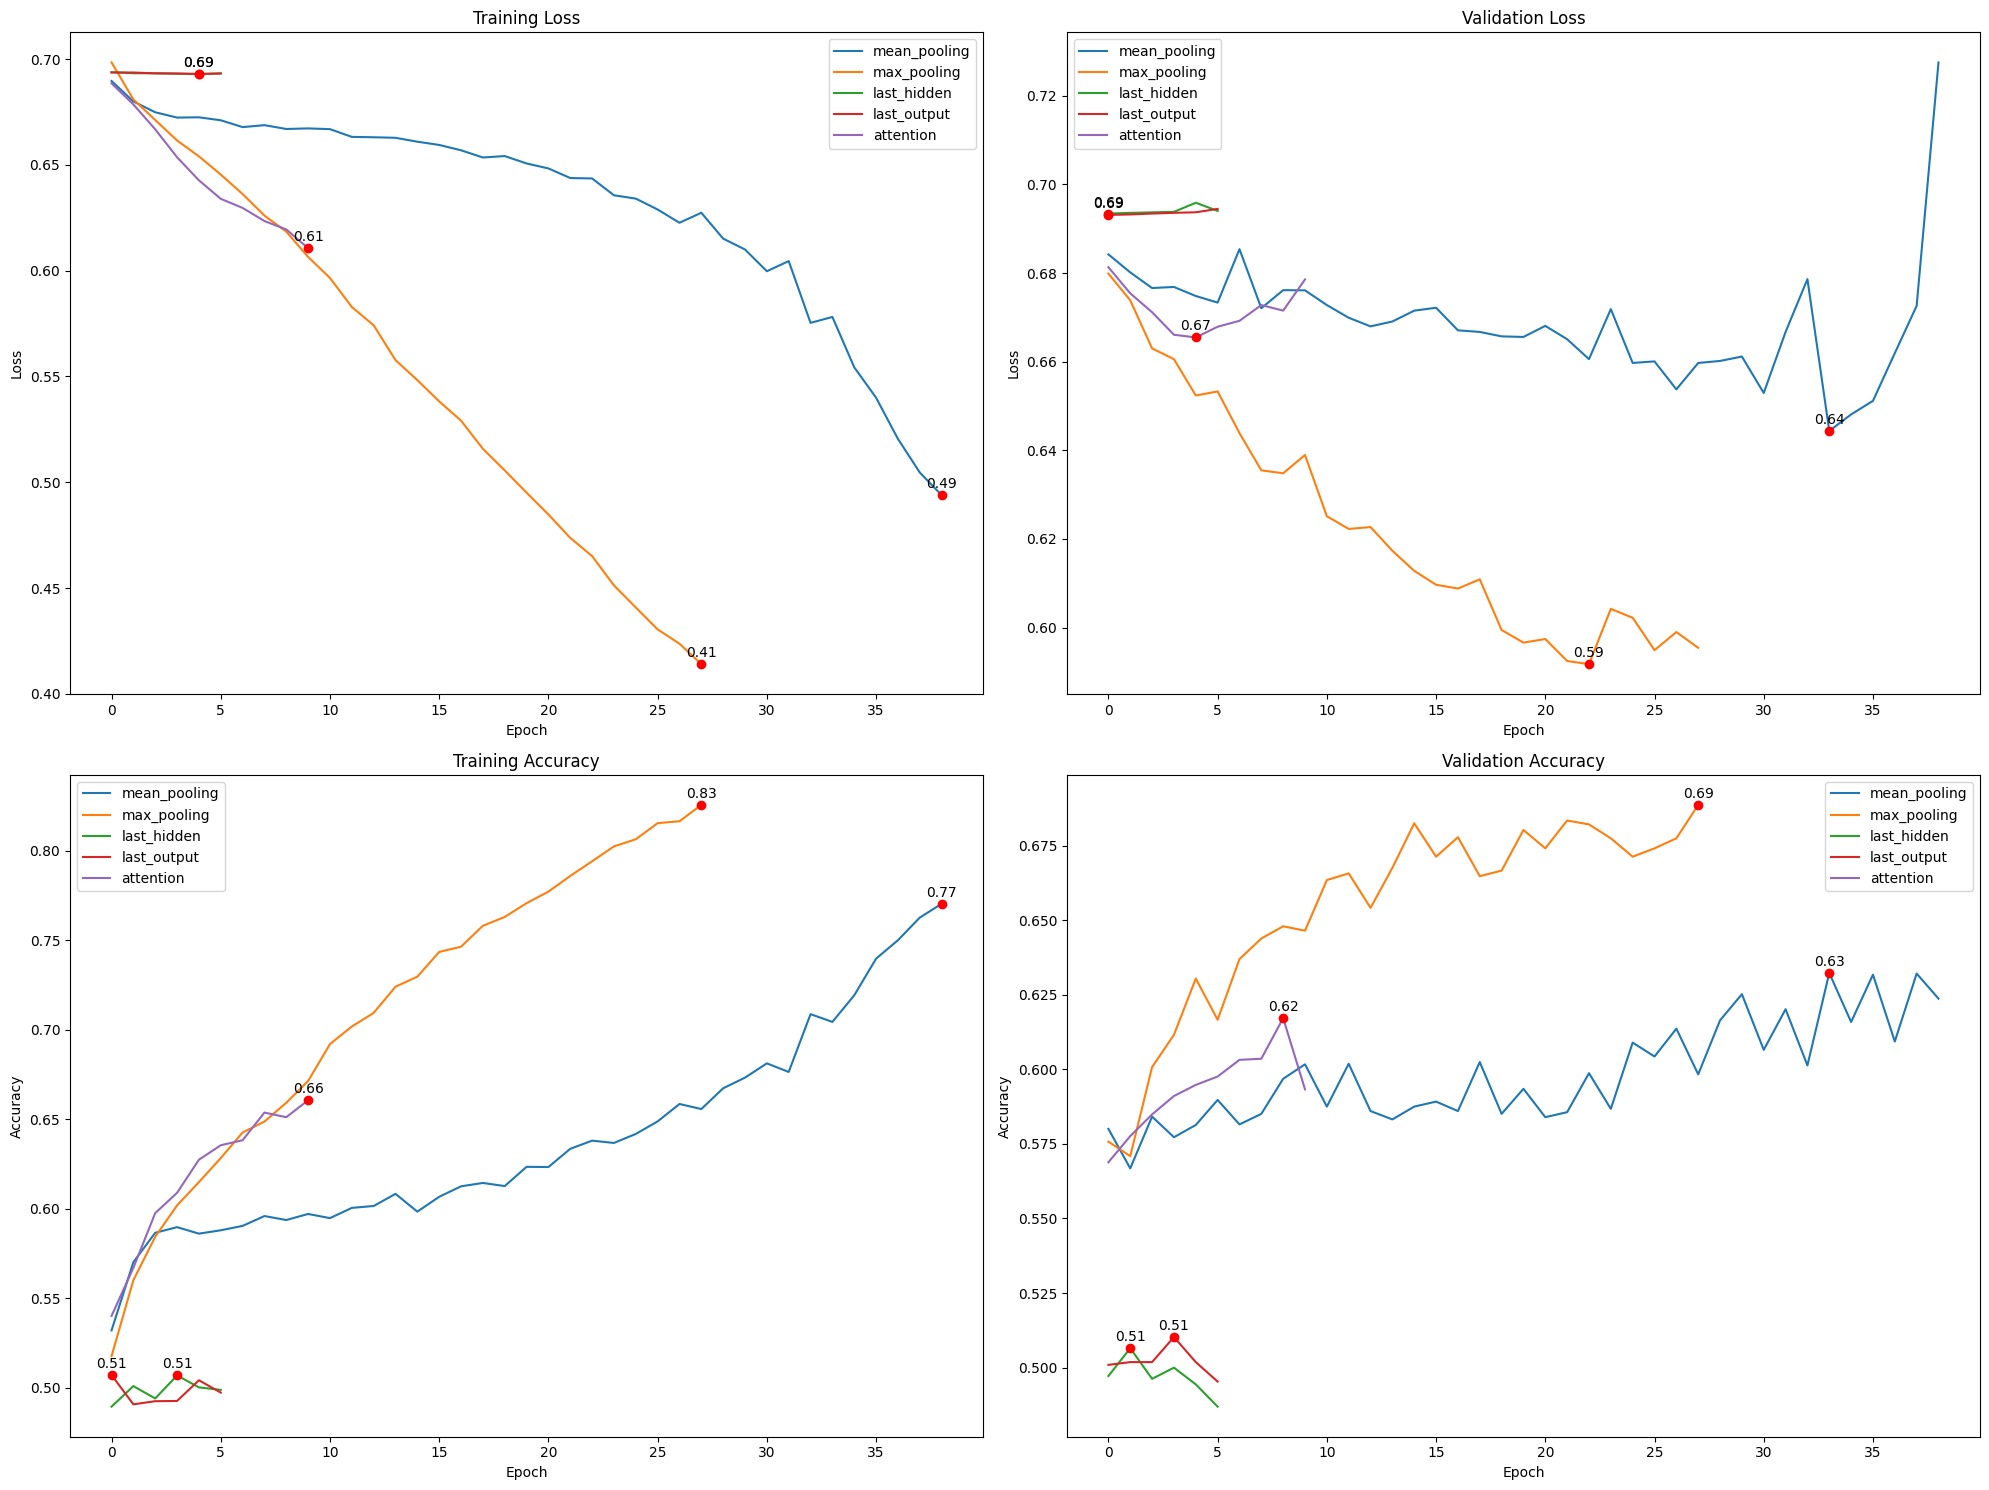

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

for method in aggregation_methods:
    # Retrieve the metrics for each method
    train_losses = results[method]['train_losses']
    val_losses = results[method]['val_losses']
    train_accs = results[method]['train_accs']
    val_accs = results[method]['val_accs']
    
    # Identify best points for highlighting
    best_train_loss_epoch = train_losses.index(min(train_losses))
    best_train_loss = min(train_losses)
    
    best_val_loss_epoch = val_losses.index(min(val_losses))
    best_val_loss = min(val_losses)
    
    best_train_acc_epoch = train_accs.index(max(train_accs))
    best_train_acc = max(train_accs)
    
    best_val_acc_epoch = val_accs.index(max(val_accs))
    best_val_acc = max(val_accs)
    
    # Plot Training Loss
    ax1.plot(train_losses, label=method)
    ax1.plot(best_train_loss_epoch, best_train_loss, 'ro')  # Red dot at the best point
    ax1.annotate(f"{best_train_loss:.2f}", (best_train_loss_epoch, best_train_loss), textcoords="offset points", xytext=(0,5), ha='center')
    
    # Plot Validation Loss
    ax2.plot(val_losses, label=method)
    ax2.plot(best_val_loss_epoch, best_val_loss, 'ro')  # Red dot at the best point
    ax2.annotate(f"{best_val_loss:.2f}", (best_val_loss_epoch, best_val_loss), textcoords="offset points", xytext=(0,5), ha='center')
    
    # Plot Training Accuracy
    ax3.plot(train_accs, label=method)
    ax3.plot(best_train_acc_epoch, best_train_acc, 'ro')  # Red dot at the best point
    ax3.annotate(f"{best_train_acc:.2f}", (best_train_acc_epoch, best_train_acc), textcoords="offset points", xytext=(0,5), ha='center')
    
    # Plot Validation Accuracy
    ax4.plot(val_accs, label=method)
    ax4.plot(best_val_acc_epoch, best_val_acc, 'ro')  # Red dot at the best point
    ax4.annotate(f"{best_val_acc:.2f}", (best_val_acc_epoch, best_val_acc), textcoords="offset points", xytext=(0,5), ha='center')
    
    print(f"Aggregation Method: {method}")
    print(f"Best Training Loss Epoch: {best_train_loss_epoch + 1}, Best Training Loss: {best_train_loss:.4f}")
    print(f"Best Validation Loss Epoch: {best_val_loss_epoch + 1}, Best Validation Loss: {best_val_loss:.4f}")
    print(f"Best Training Accuracy Epoch: {best_train_acc_epoch + 1}, Best Training Accuracy: {best_train_acc:.4f}")
    print(f"Best Validation Accuracy Epoch: {best_val_acc_epoch + 1}, Best Validation Accuracy: {best_val_acc:.4f}")

# Set Titles and Labels
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.set_title('Validation Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

ax3.set_title('Training Accuracy')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.legend()

ax4.set_title('Validation Accuracy')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy')
ax4.legend()

plt.tight_layout()
plt.savefig('aggregation_methods_comparison_with_best_points_all.png')
plt.show()